### Fig RNA-Seq depletion (Fig 4)
- 4A: plot % of reads mapping to mRNA, ncRNA, rRNA +/- depletion
- 4B: plot the % of reads for the rRNA transcript families +/- depletion
- 4C: plot the pre-rRNA locus coverage +/- depletion

In [1]:
#Imports
import sys
import pandas as pd
import matplotlib.pyplot as plt
import os
import gffutils
import seaborn as sns
import numpy as np
import matplotlib.ticker as plticker

sys.path.append('../scripts/')
from plot_helpers import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

db = gffutils.FeatureDB(gffutils_db)

In [2]:
#Make outdir and load the data
outdir = '../figures/F4/'
os.makedirs(outdir, exist_ok = True)

#Load abundance data
quant_file = os.path.join(results_dir, 'rnaseq_data_200723/gene_quantification/summary_abundance_by_gene_kallisto.csv')
df = pd.read_csv(quant_file, index_col = ['gene', 'symbol', 'experiment', 'replicate'])

#Get the IDs of the spike-in RNAs
allgenes = set(df.index.get_level_values('gene'))
sirvs = [i for i in allgenes if i.startswith('SIRV')]

In [3]:
#Load gene biotypes:
biotype_dict = {}
small_rnas = set(['snoRNA', 'snRNA', 'tRNA', 'pre_miRNA'])
for i in db.all_features(featuretype = 'gene'):
    this_gene = i.id
    try:
        biotype = db[this_gene].attributes['gene_biotype'][0]
        genename = db[this_gene].attributes['gene_name'][0]
        #change biotype to rRNA if rRNA is in the name -- occurs for some pseudogenes
        if 'rRNA' in genename:
            biotype = 'rRNA'
        if biotype in small_rnas:
            biotype = 'small RNA'
    except KeyError:
        biotype = 'spike-in' #only the spike-ins don't have a biotype
        
    biotype_dict[this_gene] = biotype

In [4]:
#Add biotypes to the df
df['biotype'] = df.index.get_level_values('gene').map(biotype_dict)
#set the synthetic gene biotype -- already added at previous step
#df.loc[pd.IndexSlice[sirvs], 'biotype'] = 'spike-in'
#add to the index
df.set_index('biotype', append = True, inplace = True)
df = df.reorder_levels(['gene', 'biotype', 'symbol', 'experiment', 'replicate'])
#get the sum of results by biotype
biotype_df = df.groupby(level = ['biotype', 'experiment', 'replicate']).sum()
#Get the percentage of tpm by replicate
biotype_df['percent_counts'] = biotype_df['summed_est_counts']*100/biotype_df.groupby(['experiment','replicate'])['summed_est_counts'].transform('sum')

In [5]:
#Print biotype df percentages to use for the text
biotype_df.loc[pd.IndexSlice[:, ['inputr', 'subtractedr']],].groupby(['biotype', 'experiment'])['percent_counts'].mean()

biotype         experiment 
ncRNA           inputr          0.358025
                subtractedr     7.100335
protein_coding  inputr          2.742989
                subtractedr    61.921039
pseudogene      inputr          0.001563
                subtractedr     0.035558
rRNA            inputr         96.698887
                subtractedr    27.235819
small RNA       inputr          0.088117
                subtractedr     0.866358
spike-in        inputr          0.110418
                subtractedr     2.840892
Name: percent_counts, dtype: float64

In [6]:
#Print biotype df percentages by replicate
biotype_df.loc[pd.IndexSlice[:, ['inputr', 'subtractedr']], 'percent_counts']

biotype         experiment   replicate
ncRNA           inputr       rep1          0.346666
                             rep2          0.372575
                             rep3          0.354834
                subtractedr  rep1          6.684965
                             rep2          6.546680
                             rep3          8.069360
protein_coding  inputr       rep1          2.899959
                             rep2          3.235476
                             rep3          2.093532
                subtractedr  rep1         66.067061
                             rep2         65.463034
                             rep3         54.233021
pseudogene      inputr       rep1          0.001540
                             rep2          0.001724
                             rep3          0.001426
                subtractedr  rep1          0.035040
                             rep2          0.032050
                             rep3          0.039582
rRNA            inputr   

/Users/maryk.thompson/miniconda3/envs/plotting/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


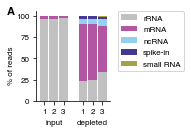

In [7]:
#Fig 4A: Stacked barplot, gene biotypes +/- subtraction
#https://chrisalbon.com/python/data_visualization/matplotlib_percentage_stacked_bar_plot/
panel_name = '4A'
plot = Plotter(corners = [0.16, 0.24, 0.4, 0.71], figsize = (dfig*1.5, dfig))
#plot = Plotter(corners = [0.2, 0.24, 0.3, 0.71], figsize = (sfig, sfig))

plot.nudge_corners(right = True)
#plot.nudge_corners(top = True, bottom = True)
plot.setup_axis()

bar_width = 0.9

num_reps = len(set(biotype_df.index.get_level_values('replicate')))
# positions of the left bar-boundaries, plotting by replicate
bar_p1 = np.array(range(num_reps))
bar_p2 = bar_p1 + 4

biotype_sums = biotype_df.groupby('biotype')['percent_counts'].sum()
biotype_sums.sort_values(ascending = False, inplace = True)
#can't visualize pseudogene on plot, <0.04% on average in subtracted
detected_biotypes = biotype_sums[biotype_sums > 1].index.tolist()

#I want the order to be rRNA, ncRNA, protein_coding
plot_order = ['rRNA', 'protein_coding', 'ncRNA']
plot_order.extend([i for i in detected_biotypes if i not in plot_order])

#https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.set_prop_cycle.html?highlight=set_prop_cycle#matplotlib.axes.Axes.set_prop_cycle
#need to reset the color cycle between the two subplots
xlabels = ['input #1', 'input #2', 'input #3', 'subtracted #1', 'subtracted #2', 'subtracted #3']
sample_l = ['inputr', 'subtractedr']
for sample, bar_l in zip(sample_l, [bar_p1, bar_p2]):
    plot.ax.set_prop_cycle(color = selected_colors)
    running_bottom = [0]*num_reps
    this_df = biotype_df.loc[pd.IndexSlice[:, sample], 'percent_counts']
    for rna in plot_order:
        values = this_df.loc[pd.IndexSlice[rna]].values
        plot.ax.bar(bar_l, 
               values,
               label = rna, 
               alpha = 0.9,
               bottom = running_bottom,
               width = bar_width,
               edgecolor = '')
        running_bottom += values

current_handles, current_labels = plt.gca().get_legend_handles_labels()

pretty_names = {'rRNA': 'rRNA', 'ncRNA':'ncRNA', 'protein_coding':'mRNA',
                'pseudogene': 'pseudogene', 'small RNA': 'small RNA', 'spike-in':'spike-in'}

#get rid of redundancy in legend plotting
legend_len = int(len(current_handles)/len(sample_l))
new_labels = [pretty_names[i] for i in current_labels[0:legend_len]]
plt.legend(current_handles[0:legend_len], new_labels, bbox_to_anchor = (1.05, 1.05), 
           ncol = 1, fontsize = 8)

plot.set_ylabel('% of reads', nudge = (0, -0.07))
plt.xticks(np.append(bar_p1, bar_p2), ['1', '2', '3', '1', '2', '3'])

plot.ax.text(1, -25, 'input', horizontalalignment='center', verticalalignment='center',
            fontsize = 8)
plot.ax.text(5, -25, 'depleted', horizontalalignment='center', verticalalignment='center',
            fontsize = 8)
plot.add_letter('A')
plt.savefig(os.path.join(outdir, '{}.{}'.format(panel_name, outfmt)), dpi = 600)

In [8]:
#Assign rRNA genes to specific families -- 18S, 28S, etc.
def rRNA_name(row):
    mito_dict = {'mt:lrRNA': 'mito_large', 'mt:srRNA': 'mito_small'} 
    if row in mito_dict:
        return mito_dict[row]
    #count the pseudogenes toward the main family 18SrRNA-Psi -> 18SrRNA
    elif 'Psi' in row:
        return row.split('-Psi')[0]
    else:
        return row.split(':')[0]
#now get percentage of counts by gene
df['percent_counts'] = df['summed_est_counts']*100/df.groupby(['experiment','replicate'])['summed_est_counts'].transform('sum')
ribo_df = df.loc[pd.IndexSlice[:, 'rRNA'], :].copy()
ribo_df['family'] = ribo_df.index.get_level_values('symbol').map(rRNA_name)
ribo_df.set_index('family', append = True, inplace = True)

family_df = ribo_df.groupby(['experiment', 'replicate', 'family'])[['percent_counts']].sum()

In [9]:
#Print the percent counts by rRNA family
this_df = family_df.loc[pd.IndexSlice[['inputr', 'subtractedr']], :].copy()
this_df.groupby(['experiment', 'family']).mean()

percent_counts
experiment  family                    
inputr      18SrRNA          35.210419
            28SrRNA          60.496854
            2SrRNA            0.000000
            5.8SrRNA          0.420993
            5SrRNA            0.066680
            mito_large        0.142321
            mito_small        0.062132
            pre-rRNA          0.299488
subtractedr 18SrRNA           4.838162
            28SrRNA           9.569672
            2SrRNA            0.000000
            5.8SrRNA          4.760933
            5SrRNA            0.036196
            mito_large        4.215072
            mito_small        1.625329
            pre-rRNA          2.190454

In [10]:
#If the counts are scaled by spike-ins, then the fold decrease looks similar to that obtained from the qPCR measurements:
family_df2 = ribo_df.groupby(['experiment', 'replicate', 'family'])[['summed_est_counts']].sum()
this_df2 = family_df2.loc[pd.IndexSlice[['inputr', 'subtractedr']], :].copy()
sirv_df = biotype_df.loc[pd.IndexSlice['spike-in']].copy().rename(columns = {'summed_est_counts': 'spike_counts'})
t = pd.merge(this_df2, sirv_df['spike_counts'], left_index = True, right_index = True)
t['normalized_counts'] = t['summed_est_counts']/t['spike_counts']
t.reset_index('experiment', inplace = True)
ratio_df = t.loc[t['experiment'] == 'subtractedr', ['normalized_counts']]/t.loc[t['experiment'] == 'inputr', ['normalized_counts']]
ratio_df.groupby('family').mean()*100

,normalized_counts
family,
18SrRNA,0.527747
28SrRNA,0.611973
2SrRNA,NaN
5.8SrRNA,44.995481
5SrRNA,2.178008
mito_large,115.088161
mito_small,102.146697
pre-rRNA,28.325124


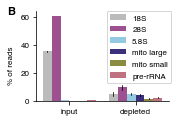

In [11]:
#Fig 4B, Plot rRNA by transcript family
panel_name = '4B'
plot = Plotter(corners = [0.16, 0.24, 0.71, 0.71], figsize = (dfig*1.5, dfig))

#this looks OK for putting the legend to the side of the plot
#plot = Plotter(corners = [0.12, 0.24, 0.53, 0.71], figsize = (dfig*2, dfig))

plot.nudge_corners(left = True)
plot.setup_axis()

this_df = family_df.loc[pd.IndexSlice[['inputr', 'subtractedr']], :].copy()

#exclude transcripts that have <1% counts in any library -- i.e. 5S and 2S
plot.ax = sns.barplot(x="experiment", y="percent_counts", hue = 'family', ci = 'sd',
            data = this_df[this_df.groupby('family')['percent_counts'].transform('max') > 1]
            .reset_index(level = ['experiment', 'family', 'replicate']), ax = plot.ax)

current_handles, current_labels = plt.gca().get_legend_handles_labels()
pretty_names = {'18SrRNA': '18S', '28SrRNA':'28S', 'mito_large':'mito large',
                'mito_small': 'mito small', 'pre-rRNA':'pre-rRNA',
                '2SrRNA': '2S', '5SrRNA': '5S', '5.8SrRNA': '5.8S'}

plt.legend(current_handles, [pretty_names[i] for i in current_labels], bbox_to_anchor = (1.05, 1.05), 
           ncol = 1, fontsize = 8)

lines = plot.ax.lines
for line in lines:
    line.set_linewidth(0.75)
    line.set_color('k')

plot.set_ylabel('% of reads', nudge = (0, -0.07))
plot.ax.set_xticklabels(['input', 'depleted'])
plot.ax.set_xlabel('')
plot.add_letter('B')
plt.savefig(os.path.join(outdir, '{}.{}'.format(panel_name, outfmt)), dpi = 600)

In [12]:
#Fig 4C: Plot the spike-in scaled coverage over a pre-rRNA locus

#bedgraph files
this_dir = os.path.join(results_dir, 'rnaseq_data_200723/rrna_coverage')
bedgraph_files = {'inputr':[os.path.join(this_dir, i) for i in ['inputr-rep1.rrna_bedgraph', 'inputr-rep2.rrna_bedgraph', 'inputr-rep3.rrna_bedgraph']], 
            'subtractedr':[os.path.join(this_dir, i) for i in ['subtractedr-rep1.rrna_bedgraph', 'subtractedr-rep2.rrna_bedgraph', 'subtractedr-rep3.rrna_bedgraph']]}

#preRNA: rDNA:66,807..74,924 [+]
#18S: rDNA:67,668..69,662 [+]
#28S: rDNA:70,955..74,924 [+]
#mir: rDNA:70,290..70,358 [+]
#5.8S: rDNA:70,389..70,511 [+]
#2S: rDNA:70,540..70,569 [+]

#these are the 1-based regions on the rDNA chromosome
region_dict = {'18S': [67668, 69662], '2S': [70540, 70569], '28S': [70955, 74924], 
               'pre-rRNA': [66807, 74924], '5.8S': [70389, 70511], 
               'mir-10404-1': [70290, 70358]}

#Get the SIRV spike-in counts by replicate
sirv_df = df[df.index.get_level_values('gene').isin(sirvs)].copy()
sirv_sum_df = sirv_df.groupby(['experiment', 'replicate'])['summed_est_counts'].sum()

#Get the total counts by replicate
total_count_df = df.groupby(['experiment', 'replicate'])['summed_est_counts'].sum()

In [13]:
#Get normalized read depth of input and depleted experiments
def extract_rrna_counts(bedgraph_file, spike_counts, start, end):
    '''
    Extract region corresponding to pre-rRNA, convert to array of counts,
    and scale by the spike counts.
    Note the bedgraph file is in 0-based, half-open.
    http://genome.ucsc.edu/goldenPath/help/bedgraph.html
    '''
    df = pd.read_table(bedgraph_file, header = None, names = ['chrom', 'start', 'end', 'counts'])    
    sub_df = df[(df['end'] > start) & (df['start'] <= end)].copy()
    count_a = np.full(0, 0)
    for i in sub_df.itertuples():
        range_start = max(i.start, start)
        range_end = min(i.end, end)
        range_len = range_end - range_start
        a = np.full(range_len, i.counts)
        count_a = np.append(count_a, a)

    scaled_a = count_a * (1/spike_counts)
    return count_a, scaled_a

reps = ['rep1', 'rep2', 'rep3']
#-1 to make 0-based
start = region_dict['pre-rRNA'][0] - 1
#add 20 nt to the end to prevent the arrow head from getting clipped off
end = region_dict['pre-rRNA'][1] + 20

scaled_dict = {}
unscaled_dict = {}
for exp in ['inputr', 'subtractedr']:
    l = []
    l2 = []
    for i, bedgraph in enumerate(bedgraph_files[exp]):
        rep = reps[i]
        million_counts = total_count_df.loc[pd.IndexSlice[exp, rep]]/1e6
        spike_counts = sirv_sum_df.loc[pd.IndexSlice[exp, rep]]
        counts, scaled_counts = extract_rrna_counts(bedgraph, spike_counts, start, end)
        l.append(scaled_counts)
        l2.append(counts)
    scaled_dict[exp] = sum(l)
    unscaled_dict[exp] = sum(l2)

#normalize so that max value in window = 1
max_value = max(max(scaled_dict['inputr']), max(scaled_dict['subtractedr']))
norm_factor = 1/max_value
for exp in scaled_dict:
    scaled_dict[exp] = scaled_dict[exp]*norm_factor

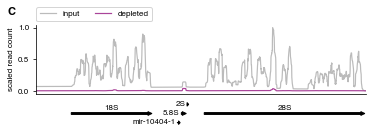

In [15]:
#Plot 4C: Plot coverage over the pre-rRNA locus
panel_name = '4C'
plot = Plotter(corners = [0.08, 0.3, 0.87, 0.55], figsize = (dfig*3, dfig))
plot.setup_axis()

#add 1 to adjust back to 1-based coordinates for plotting
start_i = start + 1
end_i = end + 1

input_cov, = plot.ax.plot(range(start_i, end_i), scaled_dict['inputr'], linewidth = 1.2)
depleted_cov, = plot.ax.plot(range(start_i, end_i), scaled_dict['subtractedr'], linewidth = 1.2)

plot.set_ylabel('scaled read count')
plot.ax.set_xlabel('')
plot.ax.set_xticklabels([])
plot.ax.set_xticks([])
##plot.ax.set_xlim(start_i, end_i)
#plot.ax.set_ylim(0, 1.05)
plot.ax.set_xlim(start_i, end_i)
##loc = plticker.MultipleLocator(base=1.0)
##plot.ax.yaxis.set_major_locator(loc)

plot.ax.legend([input_cov, depleted_cov], ['input', 'depleted'], 
               fontsize = 8, ncol = 3, bbox_to_anchor=(0., 1.05, 1., .102), loc=3, 
               borderaxespad=0.)

plot.add_letter('C')

#add another axis below to plot the gene diagram
plot.corners = [0.08, 0, 0.87, 0.29]
plot.setup_axis(new_fig = False)

plot.ax.set_xlim(start_i, end_i)
for gene in region_dict:
    gene_len = region_dict[gene][1] - region_dict[gene][0] + 1
    gene_start = region_dict[gene][0]
    gene_mid = gene_start + gene_len/2
    
    if (gene == '18S') or (gene == '28S'):
        plot.ax.text(gene_mid, 0.6, gene, ha = 'center', fontsize = 8)
        plot.ax.arrow(gene_start, 0.5, gene_len, 0, width = 0.05, 
                      length_includes_head = True, shape = 'full', 
                      head_width=0.1, head_length=100, edgecolor = None, facecolor = 'k')
    elif gene == '5.8S':
        plot.ax.text(gene_start - 40, 0.5, gene, ha = 'right', va = 'center', fontsize = 8)
        plot.ax.arrow(gene_start, 0.5, gene_len, 0, width = 0.05, 
                      length_includes_head = True, shape = 'full', 
                      head_width=0.1, head_length=100, edgecolor = None, facecolor = 'k')
    elif gene == '2S':
        plot.ax.text(gene_start - 40 , 0.75, gene, ha = 'right', va = 'center', fontsize = 8)
        plot.ax.arrow(gene_start, 0.75, gene_len, 0, width = 0.01, 
                      length_includes_head = True, shape = 'full', head_width=0.1, head_length=40, 
                      edgecolor = None, facecolor = 'k')
    elif gene == 'mir-10404-1':
        plot.ax.text(gene_start - 40 , 0.25, gene, ha = 'right', va = 'center', fontsize = 8)
        plot.ax.arrow(region_dict[gene][0], 0.25, gene_len, 0, width = 0.01, length_includes_head = True, 
                      shape = 'full', head_width=0.1, head_length=40, 
                      edgecolor = None, facecolor = 'k')
    else:
        continue

plot.ax.spines['bottom'].set_visible(False)
plot.ax.spines['left'].set_visible(False)
plot.ax.set_yticklabels([])
plot.ax.set_xticklabels([])
plot.ax.set_xticks([])
plot.ax.set_yticks([])
plot.ax.set_xlim(start_i, end_i)

plt.savefig(os.path.join(outdir, '{}.{}'.format(panel_name, outfmt)), dpi = 600)